In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob
import copy
import pandas as pd
import cartopy.crs as ccrs
import datetime
import os

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39873,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:44183,Total threads: 7
Dashboard: /proxy/42523/status,Memory: 31.50 GiB
Nanny: tcp://127.0.0.1:45851,


# All points together:

In [3]:
def Gaussian(ds, xpos, ypos, xscale, yscale, amp):
    '''
    Scaling field: Gaussian in x,y,t
    '''
    varname = list(ds.data_vars.keys())[0]  # NB: assumes only one data variable
    x, y = np.meshgrid(ds.longitude.data, ds.latitude.data)
    spatial = np.exp(
             -((x-xpos)/xscale)**2 
             -((y-ypos)/yscale)**2 )
    for t in ds.time:
        scaling_field = 1 + amp*spatial
        ds[varname].loc[dict(time=t)] = scaling_field
    return

In [21]:
base_in = '/g/data/rt52/era5/single-levels/reanalysis/10v/'
base_out = '/g/data/e14/rmh561/access-om2/input/ERA-5/IAF/scaling/'

bad_points = [{'tstart':'1984-08-11T15:00:00','tmid':'1984-08-11T18:00:00','tend':'1984-08-11T21:00:00','xpos':137.5,'ypos':-5.75,'xscale':2,'yscale':2,'amp':-0.99},
              {'tstart':'1986-07-24T06:00:00','tmid':'1986-07-24T09:00:00','tend':'1986-07-24T10:00:00','xpos':164,'ypos':-74,'xscale':3,'yscale':3,'amp':-0.99},
              {'tstart':'1992-11-13T15:00:00','tmid':'1992-11-13T20:00:00','tend':'1992-11-13T21:00:00','xpos':137.75,'ypos':-5.5,'xscale':3,'yscale':3,'amp':-0.99},
              {'tstart':'1993-06-24T05:00:00','tmid':'1993-06-24T07:00:00','tend':'1993-06-24T09:00:00','xpos':164,'ypos':-74,'xscale':3,'yscale':3,'amp':-0.99}]   

u10 max = 19.24, u10-scaled max = 19.24, v10 max = 131.37, v10-scaled max = 19.42
u10 max = 40.75, u10-scaled max = 28.44, v10 max = 130.14, v10-scaled max = 25.16
u10 max = 25.30, u10-scaled max = 19.72, v10 max = 24.73, v10-scaled max = 20.79
u10 max = 100.17, u10-scaled max = 24.93, v10 max = 22.04, v10-scaled max = 22.04


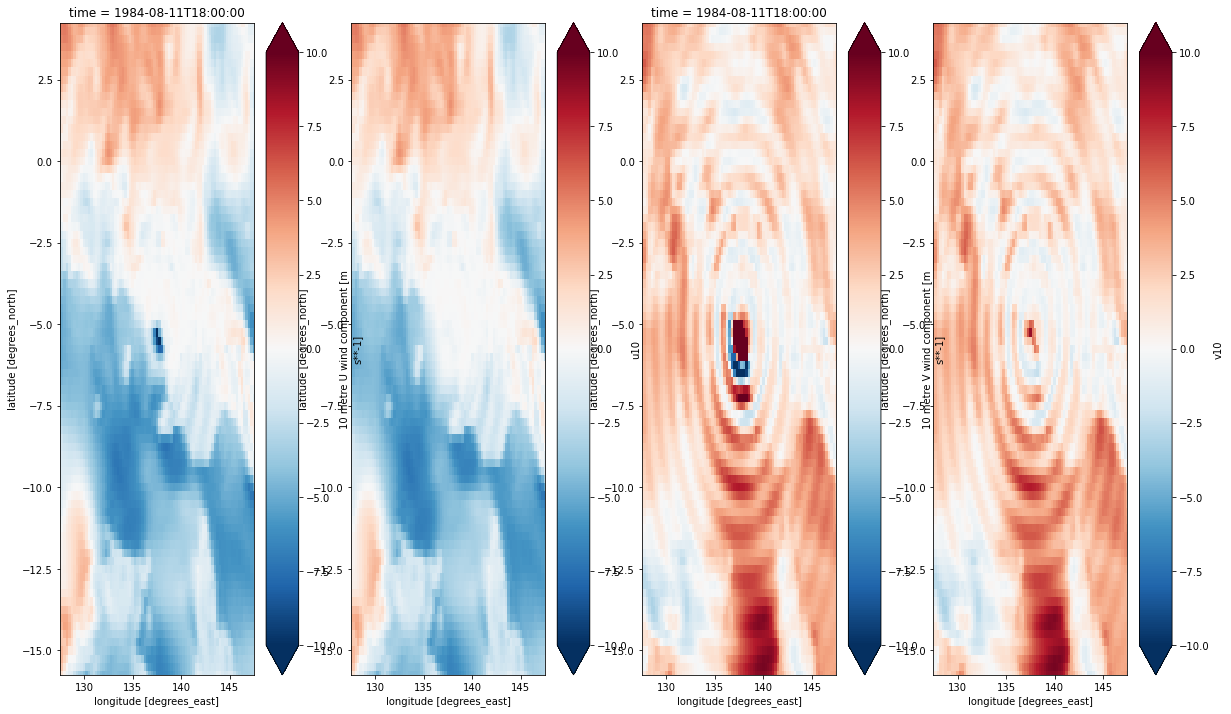

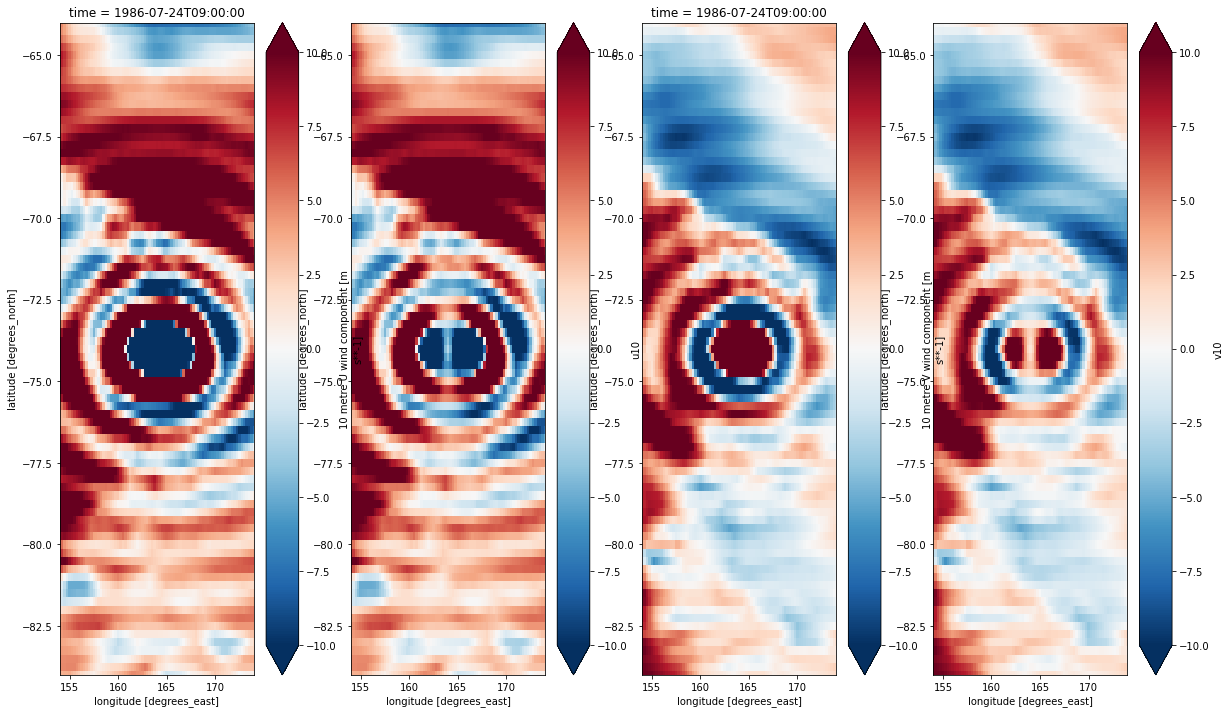

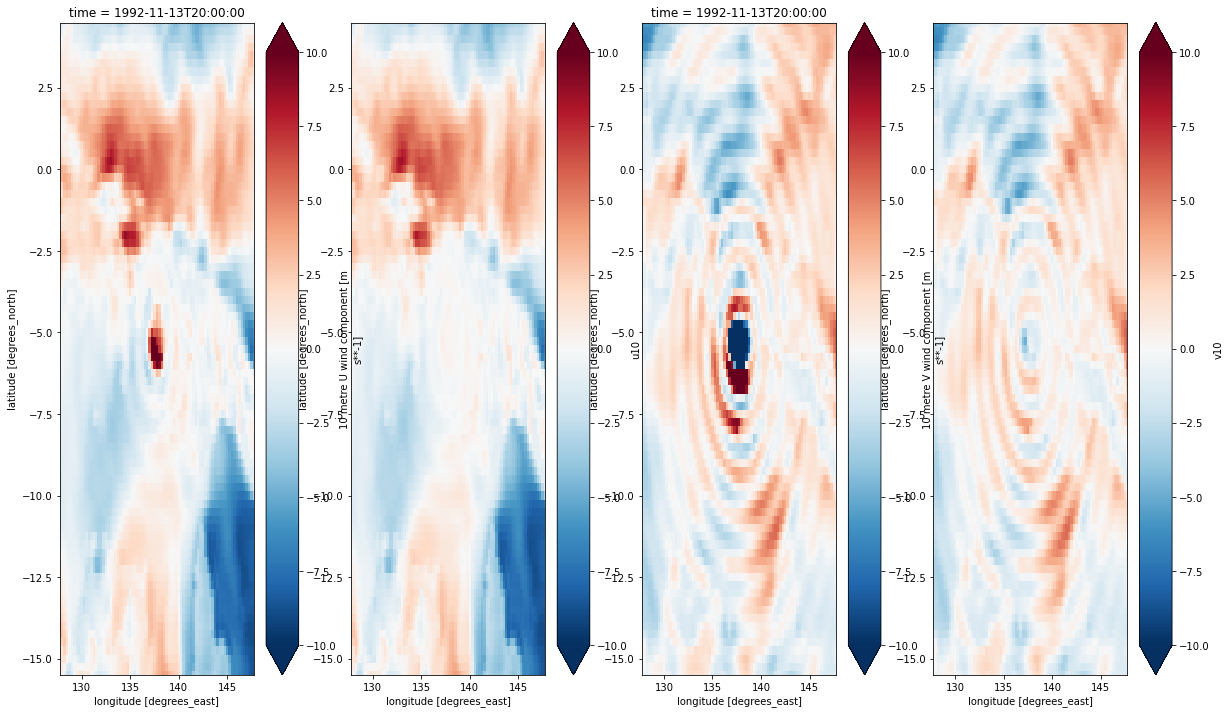

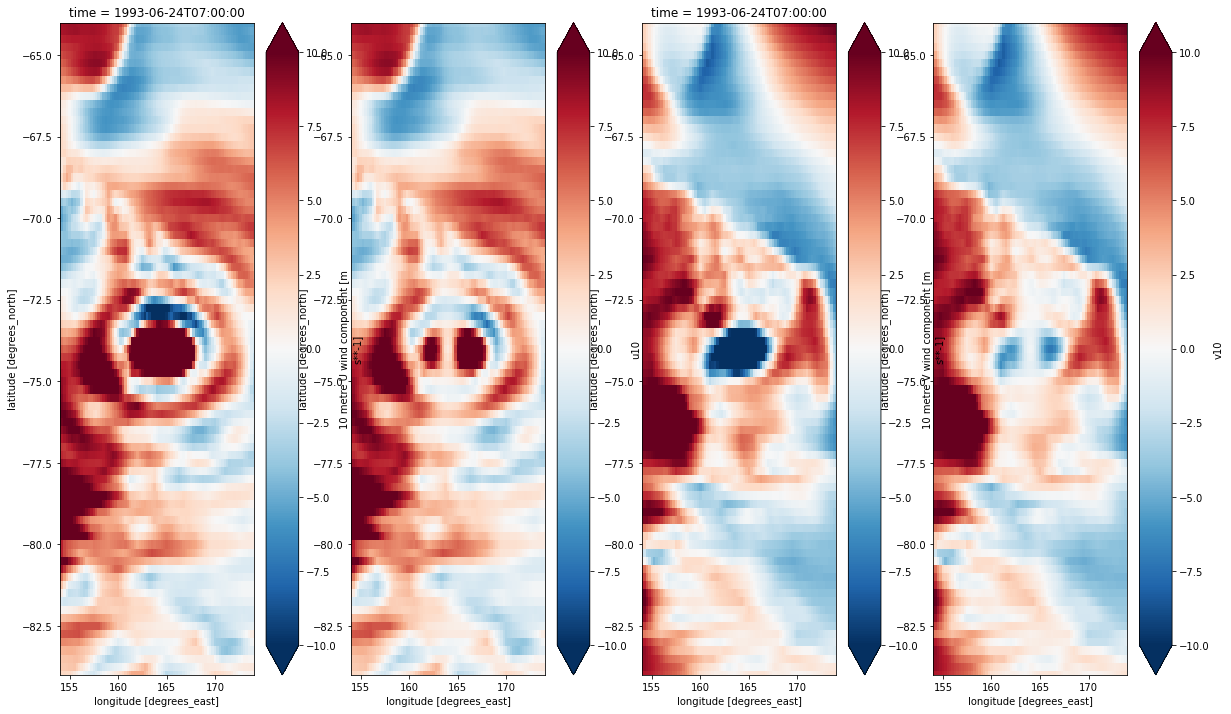

In [29]:
# Do a single point:
pts = [0,1,2,3]
dry = True # If true, just plot, don't create scaling file

for pt in pts:
    year = bad_points[pt]['tstart'][:4]
    month = bad_points[pt]['tstart'][5:7]
    file_in = [glob.glob(base_in + str(year) + '/10v_era5_oper_sfc_' + str(year) + str(month) + '*.nc')[0],
               glob.glob(base_in.replace('10v','10u') + str(year) + '/10u_era5_oper_sfc_' + str(year) + str(month) + '*.nc')[0]]
    file_out = [base_out + '10v_era5_oper_sfc_' + str(year) + '_scaling.nc',
                base_out + '10u_era5_oper_sfc_' + str(year) + '_scaling.nc']

    # now make the scaling field, preserving the ERA-5 file structure

    # x,y,t location of Gaussian centre
    xpos = bad_points[pt]['xpos']  # in degrees, centred on the tripole longitude 100W
    ypos = bad_points[pt]['ypos'] # in degrees, just off the coast

    # x,y,t scale of Gaussian
    xscale = bad_points[pt]['xscale']  # degrees
    yscale = bad_points[pt]['yscale']  # degrees
    amp = bad_points[pt]['amp']  # amplitude of Gaussian at centre

    tstart = bad_points[pt]['tstart']
    tmid = bad_points[pt]['tmid']
    tend = bad_points[pt]['tend']
    
    dss = []
    for i in [0,1]:
        ds_unscaled = xr.open_dataset(file_in[i]).sel(time=slice(tstart,tend))
        ds = xr.open_dataset(file_in[i]).sel(time=slice(tstart,tend))
        Gaussian(ds, xpos, ypos, xscale, yscale, amp)
        ds.attrs.update({'title': 'Scaling for ' + ds.attrs['title']})    
        ds.attrs.update({'history': 'Created ' +
                    datetime.datetime.now().replace(microsecond=0).astimezone().isoformat() + 
                    ' by rmh561 ' +
                    ' with https://github.com/rmholmes/cosima-scripts/blob/master/ERA-5/025deg_era5_iaf_v10_blowup_scaling.ipynb based on ' + 
                    file_in[i] + ' with xpos, ypos, xscale, yscale, amp = ' +
                    ', '.join([str(x) for x in [xpos, ypos, xscale, yscale, amp]])
                    })
        if not dry:
            ds.to_netcdf(file_out[i])
        dss.append(ds)

        
    fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(20,12))
    
    scalev = dss[0]
    scaleu = dss[1]
    u10 = xr.open_dataset(file_in[1])
    v10 = xr.open_dataset(file_in[0])
    
    u10_sub = u10.u10.sel(time=tmid)
    u10_sub.plot(ax=axes[0],vmin=-10,vmax=10.,cmap='RdBu_r')
    (u10_sub*scaleu.u10.isel(time=0)).plot(ax=axes[1],vmin=-10,vmax=10.,cmap='RdBu_r')
    
    v10_sub = v10.v10.sel(time=tmid)
    v10_sub.plot(ax=axes[2],vmin=-10,vmax=10.,cmap='RdBu_r')
    (v10_sub*scalev.v10.isel(time=0)).plot(ax=axes[3],vmin=-10,vmax=10.,cmap='RdBu_r')
    
    for ax in axes:
        ax.set_xlim([xpos-10,xpos+10])
        ax.set_ylim([ypos-10,ypos+10])

    print('u10 max = %3.2f, u10-scaled max = %3.2f, v10 max = %3.2f, v10-scaled max = %3.2f' % (u10_sub.max(),(u10_sub*scaleu.u10.isel(time=0)).max(),
                                                                                               v10_sub.max(),(v10_sub*scalev.v10.isel(time=0)).max()))

## Combine scaling files into a single file:

In [23]:
base = '/g/data/e14/rmh561/access-om2/input/ERA-5/IAF/scaling/'

ufiles = sorted(glob.glob(base + '10u_era5_oper_sfc_*_scaling.nc'))
vfiles = sorted(glob.glob(base + '10v_era5_oper_sfc_*_scaling.nc'))

uds = []
vds = []
for ufile in ufiles:
    ds = xr.open_dataset(ufile)
    uds.append(ds)
ds = xr.concat(uds,dim='time')
ds.to_netcdf(base + '10u_era5_oper_sfc_scaling.nc',encoding={'time':{'units': "hours since 1900-01-01",'calendar':'gregorian',"dtype": "i4"}})

for vfile in vfiles:
    ds = xr.open_dataset(vfile)
    vds.append(ds)    
ds = xr.concat(vds,dim='time')
ds.to_netcdf(base + '10v_era5_oper_sfc_scaling.nc',encoding={'time':{'units': "hours since 1900-01-01",'calendar':'gregorian',"dtype": "i4"}})